### LSTM을 활용한 자연어 문서 분류 예측 (Binary).

In [1]:
import pandas as pd
import numpy as np
import warnings    
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets.imdb import load_data, get_word_index       # Movie review data. 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, Embedding
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.callbacks import EarlyStopping
warnings.filterwarnings('ignore')                              # Turn the warnings off.
%matplotlib inline

#### 1. 데이터 불러오기:

In [2]:
n_words = 3000                                        # Vocabulary의 크기.
(X_train, y_train), (X_test, y_test) = load_data(num_words = n_words)
n_train_size = X_train.shape[0]
n_test_size = X_test.shape[0]

In [3]:
# 데이터의 Shape확인.
print("-"*50)
print("Training data X shape: {}".format(X_train.shape))
print("Training data y shape: {}".format(y_train.shape))
print("-"*50)
print("Test data X shape: {}".format(X_test.shape))
print("Test data y shape: {}".format(y_test.shape))
print("-"*50)

--------------------------------------------------
Training data X shape: (25000,)
Training data y shape: (25000,)
--------------------------------------------------
Test data X shape: (25000,)
Test data y shape: (25000,)
--------------------------------------------------


#### 2. 데이터 탐색:

In [4]:
# y의 고유한 유형의 수 = 리뷰의 유형 수 (2).
n_cat = pd.Series(y_train).nunique()
n_cat

2

In [5]:
# X에서 임의의 문서 한 개 출력.
# Embedding 층에 입력하기 위해서 정수 (인덱스)로 인코딩 되어 있다!
print(X_train[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 2, 66, 2, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 2, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 2, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 2, 16, 480, 66, 2, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 2, 15, 256, 4, 2, 7, 2, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 2, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 2, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 2, 113, 103, 32, 15, 16, 2, 19, 178, 32]


In [6]:
# 첫 100 개의 문서 길이를 확인해 본다.
# 문서 길이가 일정하지 않음을 알 수 있다.
print([len(a) for a in X_train[0:100]])

[218, 189, 141, 550, 147, 43, 123, 562, 233, 130, 450, 99, 117, 238, 109, 129, 163, 752, 212, 177, 129, 140, 256, 888, 93, 142, 220, 193, 171, 221, 174, 647, 233, 162, 597, 234, 51, 336, 139, 231, 704, 142, 861, 132, 122, 570, 55, 214, 103, 186, 113, 169, 469, 138, 302, 766, 351, 146, 59, 206, 107, 152, 186, 431, 147, 684, 383, 324, 252, 263, 787, 211, 314, 118, 390, 132, 710, 306, 167, 115, 95, 158, 156, 82, 502, 314, 190, 174, 60, 145, 214, 659, 408, 515, 461, 202, 238, 170, 107, 171]


In [7]:
# 딕셔너리를 가져온다. 인덱스로 인코딩된 문서를 단어의 조합으로 변환할 수 있게 된다.
my_dict = get_word_index(path='imdb_word_index.json')

In [8]:
# 딕셔너리 출력.
# my_dict

In [9]:
# 'key' 와 'value'의 역할을 반대로 바꾸어 준다.
# 컴프리헨션 방법을 적용한다.
my_dict_inv = {v:k for k,v in my_dict.items()}

In [10]:
# 문서를 변환해서 출력해 본다.
i_review = 10                                        # 문서의 번호. 임의로 변경 가능하다.
review = list(pd.Series(X_train[i_review]).apply(lambda x: my_dict_inv[x]))
print(' '.join(review))

the clear fact entertaining there life back br is and show of performance stars br actors film him many should movie reasons to and reading and are in of scenes and and of and out compared not boss yes to and show its disappointed fact raw to it justice by br of where clear fact many your way and with city nice are is along wrong not as it way she but this anything up haven't been by who of choices br of you to as this i'd it and who of shot you'll to love for and of you it is sequels of little quest are seen watched front chemistry to simply alive of chris being it is say easy and cry in chemistry but and all it maybe this is wing film job live of and relief and level names and and to be and serial and watch is men go this of wing american from and moving is and put this of jerry for places so work and watch and lot br that from sometimes and make department introduced to and from action at turns in low that in gay i'm of chemistry and i i simply alive it is time done inspector to wat

#### 3. 데이터 전처리:

In [11]:
# Padding: 문서의 길이는 일정하게 maxlen로 맞추어 진다.
# maxlen 보다 더 길면 자르고, 더 짧으면 0으로 채워 넣는다. 
X_train = pad_sequences(X_train, maxlen = 100, padding = 'pre')    # 'pre'  앞에 0을 넣는다. 'post' 뒤에 0을 넣는다.
X_test = pad_sequences(X_test, maxlen = 100, padding = 'pre')

In [12]:
# Padding된 결과를 본다.
X_train[:3,:]

array([[1415,   33,    6,   22,   12,  215,   28,   77,   52,    5,   14,
         407,   16,   82,    2,    8,    4,  107,  117,    2,   15,  256,
           4,    2,    7,    2,    5,  723,   36,   71,   43,  530,  476,
          26,  400,  317,   46,    7,    4,    2, 1029,   13,  104,   88,
           4,  381,   15,  297,   98,   32, 2071,   56,   26,  141,    6,
         194,    2,   18,    4,  226,   22,   21,  134,  476,   26,  480,
           5,  144,   30,    2,   18,   51,   36,   28,  224,   92,   25,
         104,    4,  226,   65,   16,   38, 1334,   88,   12,   16,  283,
           5,   16,    2,  113,  103,   32,   15,   16,    2,   19,  178,
          32],
       [ 163,   11,    2,    2,    4, 1153,    9,  194,  775,    7,    2,
           2,  349, 2637,  148,  605,    2,    2,   15,  123,  125,   68,
           2,    2,   15,  349,  165,    2,   98,    5,    4,  228,    9,
          43,    2, 1157,   15,  299,  120,    5,  120,  174,   11,  220,
         175,  136,   5

In [13]:
# y는 이미 binary이기 때문에 one-hot-encoding 변환이 필요 없다.

#### 4. 딥러닝 모델 정의:

In [14]:
n_hidden = 50                   # 개개 memory cell 안의 neuron 수.
n_emb = 100                     # Embedding 공간의 차원수. 

In [15]:
# LSTM network model.
my_model = Sequential(name = "LSTM_network")
my_model.add(Embedding(n_words, n_emb, name="Embedding"))           # n_words = vocabulary 크기, n_emb = embedding 공간의 차원수.
my_model.add(LSTM(units=n_hidden, return_sequences=False, input_shape=(None, n_emb), activation='tanh', name="LSTM"))
my_model.add(Dense(1, activation='sigmoid', name="Dense"))    # Binary output!!!

In [16]:
# 모델의 summary (내부 구조) 출력.
# 모델의 summary (내부 구조) 출력.
# Embedding의 파라미터 수 = n_words * n_emb  = 3000 * 100 = 300000.  
# Embedding층의 역할은 차원 축소이다! 
# Embedding층에 개개 단어의 정수 인덱스를 입력하면 차원 축소된 밀집 벡터를 학습하게 된다! 
my_model.summary()

Model: "LSTM_network"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Embedding (Embedding)       (None, None, 100)         300000    
                                                                 
 LSTM (LSTM)                 (None, 50)                30200     
                                                                 
 Dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 330,251
Trainable params: 330,251
Non-trainable params: 0
_________________________________________________________________


#### 5. Hyperparameter 와 Optimizer 정의:

In [17]:
n_epochs = 20                      # Number of epochs.
batch_size = 64                    # Size of each batch.
learn_rate = 0.0001                 # learning rate.  

In [18]:
# Optimizer 객체 생성 후 컴파일한다.
my_optimizer=Adam(lr=learn_rate)
my_model.compile(loss = "binary_crossentropy", optimizer = my_optimizer, metrics=["accuracy"])

#### 6. 학습 & History 시각화:

In [19]:
my_EarlyStop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)          # 조기 종료 허락!
my_summary = my_model.fit(X_train, y_train, epochs=n_epochs, batch_size = batch_size, validation_split=0.2, verbose=1, callbacks=[my_EarlyStop])

Epoch 1/20
313/313 [==============================] - 22s 62ms/step - loss: 0.6446 - accuracy: 0.6291 - val_loss: 0.5006 - val_accuracy: 0.7572
Epoch 2/20
313/313 [==============================] - 15s 47ms/step - loss: 0.4254 - accuracy: 0.8127 - val_loss: 0.3996 - val_accuracy: 0.8220
Epoch 3/20
313/313 [==============================] - 19s 61ms/step - loss: 0.3528 - accuracy: 0.8526 - val_loss: 0.3800 - val_accuracy: 0.8314
Epoch 4/20
313/313 [==============================] - 19s 61ms/step - loss: 0.3233 - accuracy: 0.8644 - val_loss: 0.3688 - val_accuracy: 0.8340
Epoch 5/20
313/313 [==============================] - 17s 54ms/step - loss: 0.3061 - accuracy: 0.8750 - val_loss: 0.3669 - val_accuracy: 0.8372
Epoch 6/20
313/313 [==============================] - 14s 44ms/step - loss: 0.2926 - accuracy: 0.8802 - val_loss: 0.3756 - val_accuracy: 0.8352
Epoch 7/20
313/313 [==============================] - 13s 42ms/step - loss: 0.2820 - accuracy: 0.8863 - val_loss: 0.3794 - val_accuracy:

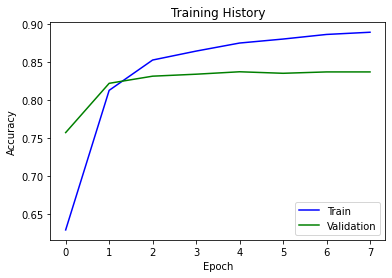

In [20]:
# 학습 history 출력. 
plt.plot(my_summary.history['accuracy'], c="b")
plt.plot(my_summary.history['val_accuracy'], c="g")
plt.title('Training History')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

#### 7. 테스팅: 

In [21]:
# 랜덤으로 테스트 문장을 추출해서 예측해 본다.
for i_test in [ random.randint(0,n_test_size-1) for _ in range(10)]:
    print("정답 :" , y_test[i_test])
    print("예측 :" , (my_model.predict(X_test[i_test].reshape(1,-1))[0][0] > 0.5)*1)       # 2 차원 배열로 reshaping 해준다!!!
    y_pred_text = " ".join([my_dict_inv[x] for x  in X_train[i_test] if x != 0 ])     # padding 을 의미하는 0을 제외하고 문자열로 변환.  
    print(y_pred_text)
    print("-"*50)

정답 : 1
1/1 [==============================] - 0s 319ms/step
예측 : 1
is script quite br older to is script quite br played was couldn't of lot know no though seen non and for died in give and to watch needs and some and all role african to care film any no all and in one and film any of left open if has my for and street in and she was lead an and and and in and she from well at and worst from real at and movie much is time played on to is and need and and of flat stars it is isn't can need on already mean
--------------------------------------------------
정답 : 0
1/1 [==============================] - 0s 15ms/step
예측 : 0
or by br were over and i i her make just didn't actors seem to of save br women like gorgeous and sex often during doing and and not from he of see huge and any her from fighting those in of work doing to by who by also and better who dad have away does when involved i i of see lot for due we with of time here that after one will half better it's between some still i i w

In [22]:
# 최종적으로 정확도 계산.
ACC = my_model.evaluate(X_test, y_test, verbose=0)[1]    
print("Test Accuracy : {}".format(np.round(ACC,3)))

Test Accuracy : 0.837
